In [2]:
# IMPORTS
import hub
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import img_as_ubyte
from glob import glob  
import tensorflow as tf
import random
import pandas as pd
from PIL import Image
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tqdm import tqdm
from PIL import Image


print('Necessary libraries are imported successfully')

Necessary libraries are imported successfully


In [3]:
# FUNCTIONS

def load_from_hub():
    # Load the data
    print("Load data...")
    ds = hub.dataset("hub://margauxmforsythe/38-cloud-segmentation")
    return ds


def convert_dataset_to_tf_dataset():
    ds_tf = ds.tensorflow()

    def to_model_fit(item):
      x = item['images']
      # Normalize
      x = x / tf.reduce_max(x)
      y = item['masks'] / 255
      return (x, y)

    ds_tf = ds_tf.map(lambda x: to_model_fit(x))
    
    print('ds_tf created successfully')
    return ds_tf


def split_dataset(image_count, batch_size):
    # max
    if image_count > 5154:
        image_count = 5154
    
    global ds_tf

    train_size = int(0.8 * image_count)
    val_size = int(0.1 * image_count)
    test_size = int(0.1 * image_count)

    ds_tf = ds_tf.shuffle(image_count)
    test_ds = ds_tf.take(test_size)
    train_ds = ds_tf.skip(test_size)
    val_ds = train_ds.take(val_size)
    train_ds = train_ds.skip(val_size)


    train_ds = train_ds.shuffle(train_size)
    train_ds = train_ds.batch(batch_size)

    val_ds = val_ds.shuffle(val_size)
    val_ds = val_ds.batch(batch_size)

    test_ds = test_ds.batch(1)
    
    print(f"{train_size} training images, {val_size} validation images and {test_size} test images. Batch size of {batch_size}")
    
    return ds_tf, train_size, val_size, test_size, train_ds, val_ds, test_ds


def unet(pretrained_weights=None, input_shape=(256, 256, 1)):
  inputs = Input(input_shape)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis=3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)

  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
  
  model = Model(inputs=inputs, outputs=conv10)

  # model.summary()

  if(pretrained_weights):
      model.load_weights(pretrained_weights)

  return model


def dice_loss(y_true, y_pred):
    smooth = 1e-5
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice_coef = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice_coef


def config():
    if not os.path.isdir("./checkpoints"):
        print("Create folder checkpoints")
        os.mkdir("./checkpoints")

    global model
    global checkpoint_callback

    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('./checkpoints/weights.epoch-{epoch:02d}-val-iou-{val_iou:.4f}.hdf5',
                                                     monitor='val_iou', 
                                                     mode='max', verbose=1,
                                                     save_best_only=True,
                                                     save_weights_only=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=dice_loss,
                  metrics=['binary_accuracy', tf.keras.metrics.Recall(name="recall"), 
                           tf.keras.metrics.Precision(name="precision"), 
                           tf.keras.metrics.MeanIoU(num_classes=2, name='iou')]) 
    
    print('Configuration are done succesfully')
    

def plot_dataset_random(N):
    fig = plt.figure(figsize=(5, 2*N))
    columns = 2
    rows = N

    # Define column titles
    column_titles = ['False Colour', 'Ground Truth']

    i = 1
    for img, label in ds_tf.shuffle(N):
        if i == columns * rows + 1:
            break
        ax1 = fig.add_subplot(rows, columns, i)
        ax1.imshow(img[:,:,0])
        if i == 1:
            ax1.set_title(column_titles[0])  # Set title for the first column

        ax2 = fig.add_subplot(rows, columns, i + 1)
        label = label.numpy()
        ax2.imshow(convert_to_RBG(label[:,:,0]))
        if i == 1:
            ax2.set_title(column_titles[1])

        i = i + len(column_titles)

    plt.show()
    

def convert_to_RBG(img):
    rgb = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            pixel = img[i, j]
            if pixel == 0 or not pixel:
                rgb[i, j] = [0, 0, 0]
            elif pixel == 1 or pixel:
                rgb[i, j] = [255, 255, 255]

    return rgb


def create_overlaid_image(groundtruth, prediction):
    # Create a new array with the same shape as the input images
    overlaid = np.zeros((groundtruth.shape[0], groundtruth.shape[1], 3), dtype=np.uint8)
    r_groundtruth = convert_to_RBG(groundtruth)
    r_prediction = convert_to_RBG(prediction)

    # Iterate over each pixel
    for i in range(groundtruth.shape[0]):
        for j in range(groundtruth.shape[1]):
            gt_pixel = r_groundtruth[i, j]
            pred_pixel = r_prediction[i, j]

            # Check the conditions and set the corresponding color
            if np.array_equal(gt_pixel, [0, 0, 0]):
                if np.array_equal(pred_pixel, [0, 0, 0]):
                    overlaid[i, j] = [0, 0, 0]  # Black
                elif np.array_equal(pred_pixel, [255, 255, 255]):
                    overlaid[i, j] = [128, 0, 128]  # Purple
            elif np.array_equal(gt_pixel, [255, 255, 255]):
                if np.array_equal(pred_pixel, [0, 0, 0]):
                    overlaid[i, j] = [0, 128, 0]  # Green
                elif np.array_equal(pred_pixel, [255, 255, 255]):
                    overlaid[i, j] = [255, 255, 255]  # White

    return r_groundtruth, r_prediction, overlaid


def plot_result(N):
    fig = plt.figure(figsize=(10, 2*N))
    columns = 4
    rows = N

    # Define column titles
    column_titles = ['False Colour', 'Ground Truth', 'Predicted', 'Result']

    i = 1
    for img, label in test_ds:
        if i == columns * rows + 1 or (i+3)//4 == N+1:
            break
        pred = (model.predict(img)[0] > 0.5)    # Plot the original image in the left subplot

        
        # Convert EagerTensor to NumPy array
        label = label.numpy()
        r_groundtruth, r_prediction, overlaid = create_overlaid_image(label[0][:,:,0], pred[:,:,0])
    # show false colour
        ax1 = fig.add_subplot(rows, columns, i)
        ax1.imshow(img[0][:,:,0])
        if i == 1:
            ax1.set_title(column_titles[0])  # Set title for the first column

    # show groundtruth
        ax2 = fig.add_subplot(rows, columns, i + 1)
        ax2.imshow(r_groundtruth)
        if i == 1:
            ax2.set_title(column_titles[1])  # Set title for the second column

    #show prediction
        ax3 = fig.add_subplot(rows, columns, i + 2)
        ax3.imshow(r_prediction)
        if i == 1:
            ax3.set_title(column_titles[2])  # Set title for the second column


    # show overlaid result
        ax4 = fig.add_subplot(rows, columns, i + 3)
        ax4.imshow(overlaid)
        if i == 1:
            ax4.set_title(column_titles[3])  # Set title for the second column

        i = i + 4

    plt.show()


print('Functions are defined successfully')

Functions are defined successfully


In [4]:
ds = load_from_hub()

Load data...


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/margauxmforsythe/38-cloud-segmentation



/

hub://margauxmforsythe/38-cloud-segmentation loaded successfully.



In [5]:
ds_tf = convert_dataset_to_tf_dataset()

ds_tf created succesfully


In [6]:
ds_tf, train_size, val_size, test_size, train_ds, val_ds, test_ds = split_dataset(image_count=5154, batch_size=4)

4123 training images, 515 validation images and 515 test images. Batch size of 4


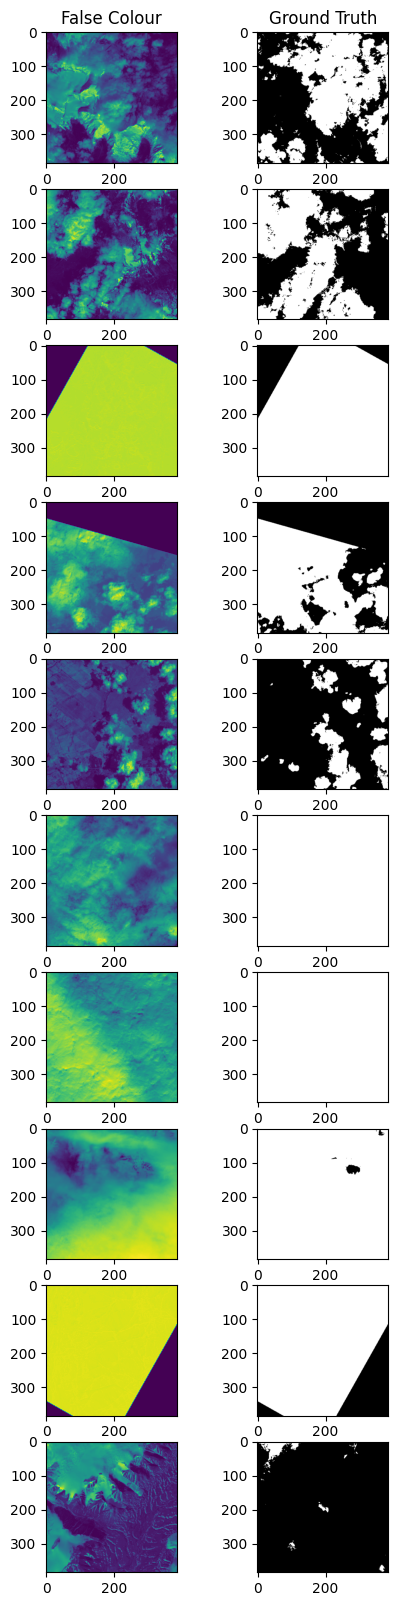

In [7]:
plot_dataset_random(N=10)

In [8]:
model = unet(input_shape = (384,384,4)) # pretrained_weights="./checkpoints/weights.epoch-08-val-iou-0.2763.hdf5"

In [9]:
config()

Configuration are done succesfully


In [10]:
model.fit(train_ds, 
          validation_data=val_ds, 
          epochs = 20,
          callbacks = [checkpoint_callback])

Epoch 1/20
   1032/Unknown - 856s 545ms/step - loss: 0.2543 - binary_accuracy: 0.7278 - recall: 0.9370 - precision: 0.6556 - iou: 0.5280
Epoch 1: val_iou improved from -inf to 0.68572, saving model to ./checkpoints\weights.epoch-01-val-iou-0.6857.hdf5
1032/1032 [==============================] - 1124s 805ms/step - loss: 0.2543 - binary_accuracy: 0.7278 - recall: 0.9370 - precision: 0.6556 - iou: 0.5280 - val_loss: 0.2438 - val_binary_accuracy: 0.7488 - val_recall: 0.9682 - val_precision: 0.6597 - val_iou: 0.6857
Epoch 2/20
1032/1032 [==============================] - ETA: 0s - loss: 0.1803 - binary_accuracy: 0.8421 - recall: 0.9026 - precision: 0.7997 - iou: 0.6950
Epoch 2: val_iou improved from 0.68572 to 0.74334, saving model to ./checkpoints\weights.epoch-02-val-iou-0.7433.hdf5
1032/1032 [==============================] - 1165s 864ms/step - loss: 0.1803 - binary_accuracy: 0.8421 - recall: 0.9026 - precision: 0.7997 - iou: 0.6950 - val_loss: 0.1459 - val_binary_accuracy: 0.8949 - val

Epoch 18/20
1032/1032 [==============================] - ETA: 0s - loss: 1.0000 - binary_accuracy: 0.5054 - recall: 0.0000e+00 - precision: 0.0000e+00 - iou: 0.2527
Epoch 18: val_iou did not improve from 0.83501
1032/1032 [==============================] - 1399s 1s/step - loss: 1.0000 - binary_accuracy: 0.5054 - recall: 0.0000e+00 - precision: 0.0000e+00 - iou: 0.2527 - val_loss: 1.0000 - val_binary_accuracy: 0.5302 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_iou: 0.2651
Epoch 19/20
1032/1032 [==============================] - ETA: 0s - loss: 1.0000 - binary_accuracy: 0.5093 - recall: 0.0000e+00 - precision: 0.0000e+00 - iou: 0.2547
Epoch 19: val_iou did not improve from 0.83501
1032/1032 [==============================] - 1467s 1s/step - loss: 1.0000 - binary_accuracy: 0.5093 - recall: 0.0000e+00 - precision: 0.0000e+00 - iou: 0.2547 - val_loss: 1.0000 - val_binary_accuracy: 0.4984 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_iou: 0.2492
Epoch 20/20
1032/1

In [11]:
path_to_best_weights = "./checkpoints/weights.epoch-03-val-iou-0.8350.hdf5"
model.load_weights(path_to_best_weights) # for loading a specific set of weights
model.evaluate(test_ds)

515/515 [==============================] - 405s 47ms/step - loss: 0.2952 - binary_accuracy: 0.9162 - recall: 0.9056 - precision: 0.9309 - iou: 0.8305


[0.295192688703537,
 0.9162065982818604,
 0.9056181907653809,
 0.930881679058075,
 0.8305020332336426]

1/1 [==============================] - 0s 30ms/step


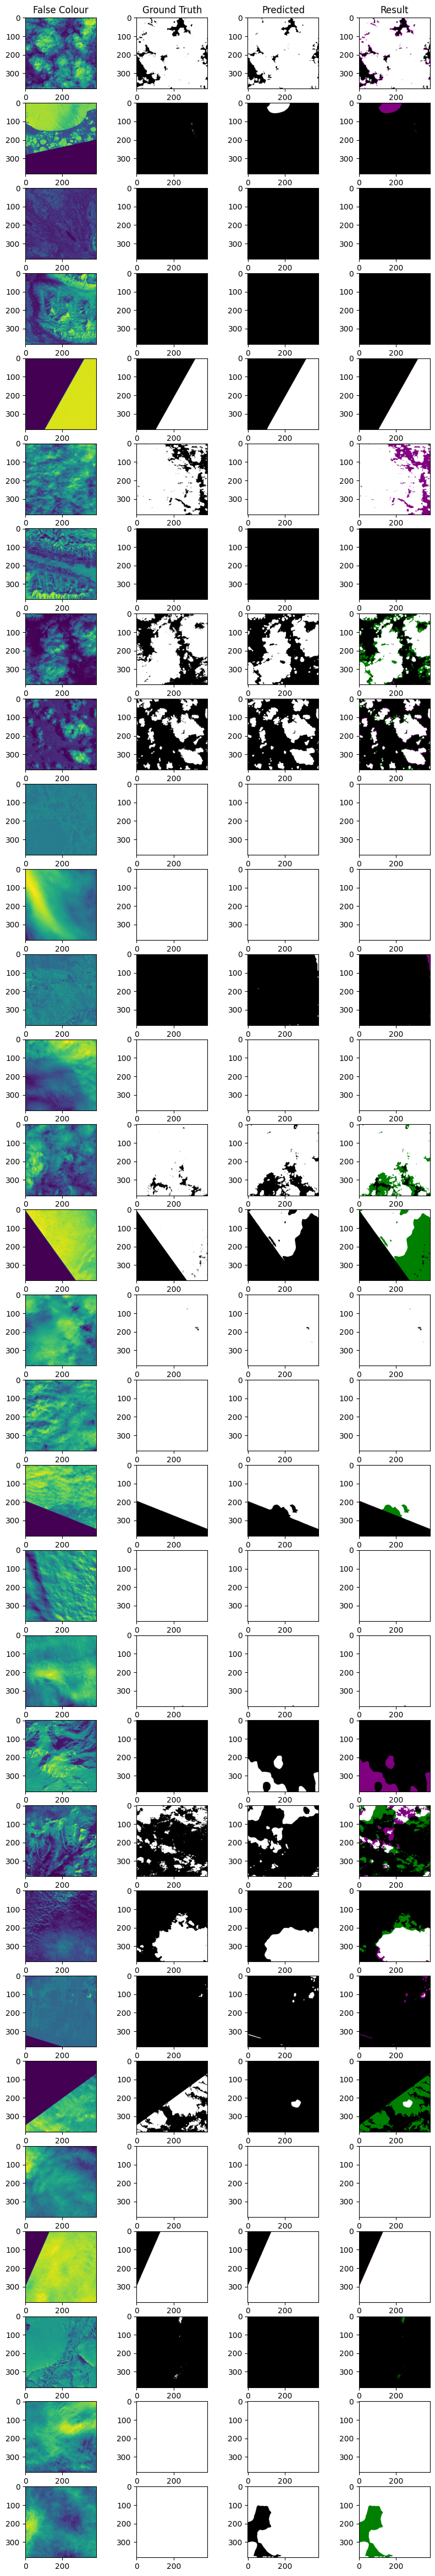

In [14]:
plot_result(N=30)